<a href="https://colab.research.google.com/github/kartikgoel1/CoughVid_Analysis/blob/main/Model_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pydub
!pip install audiomentations
!pip install librosa
!pip install imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 7.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import os
import numpy as np
import IPython.display as ipd
import librosa
import librosa.display
from audiomentations import Compose, AddGaussianNoise, PitchShift, HighPassFilter
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/cleaned_dataset.zip

Archive:  /content/drive/MyDrive/cleaned_dataset.zip
  inflating: cleaned_dataset/0029d048-898a-4c70-89c7-0815cdcf7391.wav  
  inflating: cleaned_dataset/002db0bd-e57f-4c30-ade0-16640d424eb7.wav  
  inflating: cleaned_dataset/005b8518-03ba-4bf5-86d2-005541442357.wav  
  inflating: cleaned_dataset/008ba489-31ad-44d8-856b-fcf72369dc46.wav  
  inflating: cleaned_dataset/008c1c9e-aeef-40c5-846c-24f1b964f884.wav  
  inflating: cleaned_dataset/00bf9f83-2e8f-47cf-a4f2-97f2beceebc1.wav  
  inflating: cleaned_dataset/00ce5b06-c302-4387-bbd7-86355a4a8c12.wav  
  inflating: cleaned_dataset/00ddf050-6939-4f33-9e54-fcb309b895ec.wav  
  inflating: cleaned_dataset/00eead73-a2c2-480d-b2ee-d79b1a526871.wav  
  inflating: cleaned_dataset/01430fd0-c3f1-4991-b7a7-df514285401c.wav  
  inflating: cleaned_dataset/015576c8-2b03-4dcb-b251-78a984fe86fe.wav  
  inflating: cleaned_dataset/01567151-7bb2-45ee-9aa8-a1332b5941ea.wav  
  inflating: cleaned_dataset/01614a4a-947f-43ca-a609-fc2787509f6f.wav  
  inflating

In [ ]:
cough_audio_data_path = "/content/cleaned_dataset"

In [ ]:
features_path = "/content/drive/MyDrive/cleaned_coughvid_data.csv"

In [ ]:
import pandas as pd
df = pd.read_csv(features_path)
df.head()

,uuid,cough_detected,age,gender,respiratory_condition,fever_muscle_pain,status,status_SSL,cough_type,dyspnea,wheezing,stridor,choking,congestion,nothing,diagnosis,severity
0,01567151-7bb2-45ee-9aa8-a1332b5941ea,0.9820,NaN,NaN,NaN,NaN,NaN,NaN,dry,False,False,False,True,False,False,COVID-19,mild
1,018b40a1-c109-459a-9e31-86cbd2cb3918,0.9869,NaN,NaN,NaN,NaN,NaN,NaN,wet,False,False,False,False,False,True,lower_infection,mild
2,01ff40e8-63e6-4570-a463-9778ea30cad7,0.9686,24.0,other,False,False,symptomatic,NaN,dry,False,False,False,False,False,True,healthy_cough,pseudocough
3,0379c586-c500-483c-83a6-95b63afe6931,0.9916,63.0,male,True,False,COVID-19,NaN,dry,False,False,False,False,False,True,healthy_cough,pseudocough
4,038592cb-c8db-4f55-8052-e20059146cb5,0.9824,28.0,male,False,False,healthy,NaN,dry,False,False,False,False,False,True,COVID-19,mild


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2587 entries, 0 to 2586
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   uuid                   2587 non-null   object 
 1   cough_detected         2587 non-null   float64
 2   age                    2180 non-null   float64
 3   gender                 2317 non-null   object 
 4   respiratory_condition  2317 non-null   object 
 5   fever_muscle_pain      2317 non-null   object 
 6   status                 2317 non-null   object 
 7   status_SSL             1078 non-null   object 
 8   cough_type             2587 non-null   object 
 9   dyspnea                2587 non-null   bool   
 10  wheezing               2587 non-null   bool   
 11  stridor                2587 non-null   bool   
 12  choking                2587 non-null   bool   
 13  congestion             2587 non-null   bool   
 14  nothing                2587 non-null   bool   
 15  diag

In [ ]:
print(df.columns)

Index(['uuid', 'cough_detected', 'age', 'gender', 'respiratory_condition',
       'fever_muscle_pain', 'status', 'status_SSL', 'cough_type', 'dyspnea',
       'wheezing', 'stridor', 'choking', 'congestion', 'nothing', 'diagnosis',
       'severity'],
      dtype='object')


In [ ]:
df['status'].value_counts()

symptomatic    960
healthy        735
COVID-19       622
Name: status, dtype: int64

In [ ]:
metadf2 = df[((df['cough_detected'] > 0.996) & (df['status'] == 'healthy')) |
                 ((df['cough_detected'] > 0.5) & (df['status'] == 'COVID-19')) |
                 ((df['cough_detected'] > 0.98) & (df['status'] == 'symptomatic'))]

In [ ]:
metadf2['status'].value_counts()

COVID-19       622
symptomatic    428
healthy         58
Name: status, dtype: int64

In [ ]:
newdf = metadf2
newdf

,uuid,cough_detected,age,gender,respiratory_condition,fever_muscle_pain,status,status_SSL,cough_type,dyspnea,wheezing,stridor,choking,congestion,nothing,diagnosis,severity
3,0379c586-c500-483c-83a6-95b63afe6931,0.9916,63.0,male,True,False,COVID-19,NaN,dry,False,False,False,False,False,True,healthy_cough,pseudocough
8,06e9197b-9b40-4bde-bde8-9e78242a60ac,0.9952,33.0,female,False,False,symptomatic,NaN,dry,False,False,False,False,False,True,COVID-19,mild
9,0762cd0a-5ce6-4b1b-9374-5d4396c218ed,0.8117,33.0,other,True,False,COVID-19,healthy,unknown,False,False,False,False,False,True,healthy_cough,pseudocough
10,07809b76-1f10-424e-853b-cbf4756a8ba2,0.9910,32.0,male,False,False,symptomatic,NaN,dry,False,False,False,False,False,True,lower_infection,mild
12,082991fb-ee66-4970-91dd-50890f4cc9b1,0.9431,17.0,male,True,True,COVID-19,COVID-19,dry,False,False,False,False,False,True,COVID-19,mild
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2566,f7c0a229-049b-49cb-a6f3-ad2b0e7bb90d,0.9949,52.0,female,False,False,COVID-19,healthy,dry,False,False,False,False,False,True,healthy_cough,pseudocough
2568,f8d8b216-d17d-40ce-8de6-6a889adcf016,0.9041,83.0,male,True,False,COVID-19,healthy,dry,False,False,False,False,True,False,upper_infection,mild
2577,fb6e4eac-fba3-4ab4-95ae-53488da9b68b,0.9822,28.0,male,True,False,symptomatic,healthy,dry,False,False,False,False,False,True,healthy_cough,pseudocough
2583,ff1234d7-7837-4ba7-842f-99fdc916baa9,0.9947,29.0,male,False,True,symptomatic,NaN,dry,False,False,False,False,False,True,upper_infection,mild


In [ ]:
newdf['status'].value_counts()

COVID-19       622
symptomatic    428
healthy         58
Name: status, dtype: int64

In [ ]:
newdf.isna().sum()

uuid                       0
cough_detected             0
age                       96
gender                     0
respiratory_condition      0
fever_muscle_pain          0
status                     0
status_SSL               658
cough_type                 0
dyspnea                    0
wheezing                   0
stridor                    0
choking                    0
congestion                 0
nothing                    0
diagnosis                  0
severity                   1
dtype: int64

In [ ]:
newdf = newdf.fillna("")
newdf.isna().sum()

uuid                     0
cough_detected           0
age                      0
gender                   0
respiratory_condition    0
fever_muscle_pain        0
status                   0
status_SSL               0
cough_type               0
dyspnea                  0
wheezing                 0
stridor                  0
choking                  0
congestion               0
nothing                  0
diagnosis                0
severity                 0
dtype: int64

In [ ]:
newdf.drop(newdf.loc[newdf['status']==""].index, inplace=True)
newdf

,uuid,cough_detected,age,gender,respiratory_condition,fever_muscle_pain,status,status_SSL,cough_type,dyspnea,wheezing,stridor,choking,congestion,nothing,diagnosis,severity
3,0379c586-c500-483c-83a6-95b63afe6931,0.9916,63.0,male,True,False,COVID-19,,dry,False,False,False,False,False,True,healthy_cough,pseudocough
8,06e9197b-9b40-4bde-bde8-9e78242a60ac,0.9952,33.0,female,False,False,symptomatic,,dry,False,False,False,False,False,True,COVID-19,mild
9,0762cd0a-5ce6-4b1b-9374-5d4396c218ed,0.8117,33.0,other,True,False,COVID-19,healthy,unknown,False,False,False,False,False,True,healthy_cough,pseudocough
10,07809b76-1f10-424e-853b-cbf4756a8ba2,0.9910,32.0,male,False,False,symptomatic,,dry,False,False,False,False,False,True,lower_infection,mild
12,082991fb-ee66-4970-91dd-50890f4cc9b1,0.9431,17.0,male,True,True,COVID-19,COVID-19,dry,False,False,False,False,False,True,COVID-19,mild
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2566,f7c0a229-049b-49cb-a6f3-ad2b0e7bb90d,0.9949,52.0,female,False,False,COVID-19,healthy,dry,False,False,False,False,False,True,healthy_cough,pseudocough
2568,f8d8b216-d17d-40ce-8de6-6a889adcf016,0.9041,83.0,male,True,False,COVID-19,healthy,dry,False,False,False,False,True,False,upper_infection,mild
2577,fb6e4eac-fba3-4ab4-95ae-53488da9b68b,0.9822,28.0,male,True,False,symptomatic,healthy,dry,False,False,False,False,False,True,healthy_cough,pseudocough
2583,ff1234d7-7837-4ba7-842f-99fdc916baa9,0.9947,29.0,male,False,True,symptomatic,,dry,False,False,False,False,False,True,upper_infection,mild


In [ ]:
# Feature Extraction Process
def features_extractor(file_name):
    audio, sample_rate = librosa.load(file_name)

    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=120)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_fft=2048, hop_length=512, n_mels=120)
    mel_scaled_features = np.mean(mel_spectrogram.T,axis=0)

    #stft = np.abs(librosa.stft(audio))
    #chroma = librosa.feature.chroma_stft(S=stft, sr=sample_rate)
    #chroma_scaled_features = np.mean(chroma.T,axis=0)


    return mfccs_scaled_features, mel_scaled_features #, chroma_scaled_features

In [ ]:
import numpy as np
from tqdm import tqdm
# Extract Mel Frequency Cepstral Coefficients and Mel Spectogram
extracted_features=[]
for index_num,row in tqdm(newdf.iterrows()):
    file_name = os.path.join(cough_audio_data_path,str(row["uuid"])+".wav")
    final_class_labels=row["status"]
    mfcc, melspec = features_extractor(file_name)
    extracted_features.append([mfcc,melspec,final_class_labels])

1108it [01:03, 17.49it/s]


In [ ]:
### converting extracted_features to Pandas dataframe
extracted_features_df = pd.DataFrame(extracted_features,columns=['feature1','feature2','status'])
extracted_features_df.head()

,feature1,feature2,status
0,"[-490.4076, 46.11617, -10.762878, 1.8741838, 2...","[0.009221316, 0.012443803, 0.03487042, 0.24608...",COVID-19
1,"[-395.08777, 26.69114, -32.79759, 16.642145, -...","[0.029665997, 0.033933874, 0.3531234, 2.99523,...",symptomatic
2,"[-456.92554, 30.051725, -30.964863, 10.73437, ...","[0.0018440558, 0.0042143017, 0.019523619, 0.07...",COVID-19
3,"[-493.4858, 33.047775, -19.147179, 7.2217045, ...","[0.010878492, 0.010894396, 0.009521803, 0.0176...",symptomatic
4,"[-326.88037, 51.795208, -27.632471, 32.447895,...","[0.029949127, 0.028722191, 0.21797898, 3.19366...",COVID-19


In [ ]:
# Storing extracted features into a parquet file
extracted_features_df.to_parquet("mfcc_60_coughvid.parquet", index=False)

In [ ]:
### Split the dataset into independent and dependent dataset
X1 = np.array(extracted_features_df['feature1'].tolist())
X2 = np.array(extracted_features_df['feature2'].tolist())
#X3 = np.array(extracted_features_df['feature3'].tolist()) #for a third feature (applicable if taken)
X = np.concatenate((X1, X2), axis=1)
#X = np.concatenate((X, X3), axis=1)
y = np.array(extracted_features_df['status'].tolist())

In [ ]:
X

array([[-4.9040759e+02,  4.6116169e+01, -1.0762878e+01, ...,
         5.6461866e-09,  3.6067833e-09,  3.9667461e-10],
       [-3.9508777e+02,  2.6691139e+01, -3.2797588e+01, ...,
         4.7667750e-06,  3.2786322e-06,  4.0304462e-07],
       [-4.5692554e+02,  3.0051725e+01, -3.0964863e+01, ...,
         4.6746582e-06,  3.0967935e-06,  3.4609556e-07],
       ...,
       [-5.2872021e+02,  2.2982910e+01, -5.5588431e+00, ...,
         2.7672393e-09,  1.6861892e-09,  1.9452535e-10],
       [-5.2355530e+02,  2.8345085e+01, -1.3301443e+01, ...,
         2.3524613e-09,  1.4755170e-09,  1.7451522e-10],
       [-4.3816641e+02,  3.7944069e+01, -9.4284403e-01, ...,
         3.1890752e-07,  2.1588257e-07,  2.0555488e-08]], dtype=float32)

In [ ]:
### Label Encoding
y=np.array(pd.get_dummies(y))
y.shape


(1108, 3)

In [ ]:
### Train Test Split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)

In [ ]:
# Test and Validation Split
from sklearn.model_selection import train_test_split
X_val,X_test,y_val,y_test=train_test_split(X_test,y_test,test_size=0.5,random_state=0)

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
y_test.shape


(775, 240)
(166, 240)
(167, 240)
(775, 3)
(166, 3)


(167, 3)

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

x = np.array([np.concatenate((row['feature1'], row['feature2'])) for _, row in extracted_features_df.iterrows()])
wcss = []
for i in range(1, 20):
    kmean = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmean.fit(x)
    wcss.append(kmean.inertia_)
wcss


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

[8571459.0,
 5023117.0,
 3809829.75,
 3284222.5,
 2969433.0,
 2733215.0,
 2590759.0,
 2455900.5,
 2361717.0,
 2299302.5,
 2218256.0,
 2160300.75,
 2095830.0,
 2043878.5,
 1990555.25,
 1963755.25,
 1909523.75,
 1898178.25,
 1859431.75]

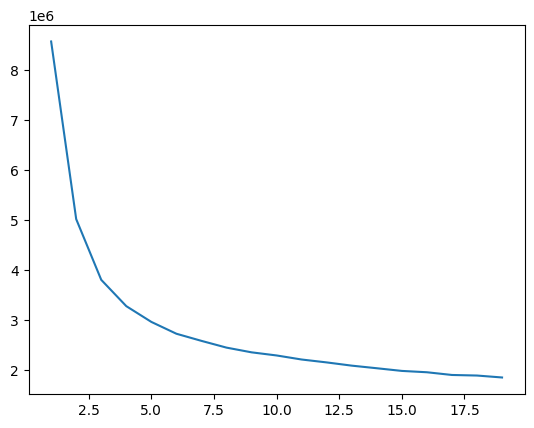

In [ ]:
plt.plot(range(1,20), wcss)

In [ ]:
kmean = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)

In [ ]:
kmean.fit(x)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3, random_state=42)

In [ ]:
clustered_data = pd.DataFrame(x)
clustered_data['cluster_number'] = kmean.predict(x)
clustered_data

,0,1,2,3,4,5,6,7,8,9,...,231,232,233,234,235,236,237,238,239,cluster_number
0,-490.407593,46.116169,-10.762878,1.874184,2.817583,0.592210,-6.708392,-6.129557,-3.375265,-3.202446,...,5.696170e-09,5.604468e-09,5.689964e-09,5.728010e-09,5.770826e-09,5.633002e-09,5.646187e-09,3.606783e-09,3.966746e-10,0
1,-395.087769,26.691139,-32.797588,16.642145,-20.226688,10.775096,-18.641010,-1.084363,-10.498213,5.987441,...,1.022804e-05,1.068359e-05,9.024977e-06,7.257127e-06,5.748772e-06,4.466263e-06,4.766775e-06,3.278632e-06,4.030446e-07,1
2,-456.925537,30.051725,-30.964863,10.734370,-15.597851,-1.865135,-12.809937,-4.630316,-7.836185,-1.874367,...,4.490261e-06,4.440362e-06,4.412126e-06,4.441586e-06,4.505741e-06,4.611600e-06,4.674658e-06,3.096794e-06,3.460956e-07,1
3,-493.485809,33.047775,-19.147179,7.221704,-5.264141,3.671988,-6.212891,-9.143614,-10.121635,-7.436742,...,4.381624e-09,3.903894e-09,3.574713e-09,3.358054e-09,3.539106e-09,3.579690e-09,3.330882e-09,2.167848e-09,2.352894e-10,0
4,-326.880371,51.795208,-27.632471,32.447895,-31.974878,22.408566,-30.968225,-2.082143,-13.851553,-4.867773,...,1.411895e-06,1.414060e-06,1.417832e-06,1.258301e-06,1.252518e-06,1.212866e-06,1.193003e-06,7.724065e-07,8.043161e-08,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1103,-534.246765,29.201427,-15.560432,6.685986,-7.603710,-2.206823,-10.634489,-0.135827,-3.413976,0.614024,...,5.697141e-09,3.961313e-09,3.565991e-09,3.380848e-09,4.303122e-09,4.256005e-09,3.696827e-09,2.327545e-09,2.407416e-10,0
1104,-522.350220,40.444836,-5.079715,-0.650967,2.528053,4.046852,-5.335165,-5.900975,-4.646565,1.056504,...,2.593692e-04,6.092995e-05,4.787299e-06,1.777285e-06,8.974734e-07,6.584013e-07,9.749795e-08,1.256841e-07,1.660222e-08,0
1105,-528.720215,22.982910,-5.558843,3.075347,-5.788859,-0.867880,-3.109370,-1.960485,0.118409,0.063198,...,5.417323e-09,3.029148e-09,2.756144e-09,2.671075e-09,2.650555e-09,2.823363e-09,2.767239e-09,1.686189e-09,1.945254e-10,0
1106,-523.555298,28.345085,-13.301443,7.336251,-10.276328,2.320531,-4.683370,-6.975243,-2.181134,-4.698476,...,2.518304e-09,2.386950e-09,2.273481e-09,2.206995e-09,2.258160e-09,2.373373e-09,2.352461e-09,1.475517e-09,1.745152e-10,0
